In [20]:
#|default_exp models.RNN

# RNNs

>These are RNN, LSTM and GRU PyTorch implementations created by Ignacio Oguiza - oguiza@timeseriesAI.co

In [21]:
#|export
from tsai.imports import *
from tsai.models.layers import *
from tsai.models.utils import *

In [76]:
#|export
class _RNN_Base(Module): #hidden_size=100, bias=True, fc_dropout=0., init_weights=True
    def __init__(self, c_in, c_out, hidden_size=1, n_layers=1, bias=False, rnn_dropout=0, bidirectional=False, fc_dropout=0.5, init_weights=False):
        self.rnn = self._cell(c_in, hidden_size, num_layers=n_layers, bias=bias, batch_first=True, dropout=rnn_dropout, 
                              bidirectional=bidirectional)
        self.dropout = nn.Dropout(fc_dropout) if fc_dropout else nn.Identity()
        self.fc = nn.Linear(hidden_size * (1 + bidirectional), c_out)
        if init_weights: self.apply(self._weights_init)

    def forward(self, x): 
        x = x.transpose(2,1)    # [batch_size x n_vars x seq_len] --> [batch_size x seq_len x n_vars]
        output, _ = self.rnn(x) # output from all sequence steps: [batch_size x seq_len x hidden_size * (1 + bidirectional)]
        output = output[:, -1]  # output from last sequence step : [batch_size x hidden_size * (1 + bidirectional)]
        output = self.fc(self.dropout(output))
        return output
    
    def _weights_init(self, m): 
        # same initialization as keras. Adapted from the initialization developed 
        # by JUN KODA (https://www.kaggle.com/junkoda) in this notebook
        # https://www.kaggle.com/junkoda/pytorch-lstm-with-tensorflow-like-initialization
        for name, params in m.named_parameters():
            if "weight_ih" in name: 
                nn.init.xavier_normal_(params)
            elif 'weight_hh' in name: 
                nn.init.orthogonal_(params)
            elif 'bias_ih' in name:
                params.data.fill_(0)
                # Set forget-gate bias to 1
                n = params.size(0)
                params.data[(n // 4):(n // 2)].fill_(1)
            elif 'bias_hh' in name:
                params.data.fill_(0)
        
class RNN(_RNN_Base):
    _cell = nn.RNN
    
class LSTM(_RNN_Base):
    _cell = nn.LSTM
    
class GRU(_RNN_Base):
    _cell = nn.GRU

In [134]:
bs = 1 #16
c_in = 1 #3
seq_len = 287 #12
c_out = 2 
xb = torch.rand(bs, c_in, seq_len) #hidden_size=100, bias=True
test_eq(RNN(c_in, c_out, hidden_size=1, n_layers=2, bias=False, rnn_dropout=0.2, bidirectional=True, fc_dropout=0.5)(xb).shape, [bs, c_out])
test_eq(RNN(c_in, c_out)(xb).shape, [bs, c_out])
test_eq(RNN(c_in, c_out, hidden_size=1, n_layers=2, bias=False, rnn_dropout=0.2, bidirectional=True, fc_dropout=0.5)(xb).shape, [bs, c_out])
test_eq(LSTM(c_in, c_out)(xb).shape, [bs, c_out])
test_eq(GRU(c_in, c_out)(xb).shape, [bs, c_out])

In [135]:
from tsai.basics import *

In [184]:
# Carregar dados de pacientes com diagnóstico de demência positivo
folder_dementia = r"C:\Users\Lenovo\Desktop\IC\[99] Database Final (16_287)\cookie_d"
data_dementia = []
for npy_file in os.listdir(folder_dementia):
    if npy_file.endswith(".npy"):
        data = np.load(os.path.join(folder_dementia, npy_file))
        data_dementia.append(data)

# Carregar dados de pacientes con diagnóstico de demência control (controle)
folder_control = r"C:\Users\Lenovo\Desktop\IC\[99] Database Final (16_287)\cookie_c/"
data_control = []
for npy_file in os.listdir(folder_control):
    if npy_file.endswith(".npy"):
        data = np.load(os.path.join(folder_control, npy_file))
        data_control.append(data)

# Combine dementia and control data
X = np.concatenate([data_dementia, data_control], axis=0)
y = np.concatenate([np.ones(len(data_dementia)), np.zeros(len(data_control))])

# Define train/validation split indices
len_dementia = len(data_dementia)
train_idx = np.arange(len_dementia)
valid_idx = np.arange(len_dementia, len(X))

# Embaralhar os índices de dados positivos e negativos
np.random.shuffle(train_idx)
split_ratio = 0.8  # Proporção para treinamento, por exemplo

# Calcular o número de amostras para cada conjunto
num_train = int(len(train_idx) * split_ratio)
num_valid = len(train_idx) - num_train

# Dividir os índices entre treinamento e validação
train_indices = train_idx[:num_train]
valid_indices = train_idx[num_train:]

# Usar os índices para dividir os dados em treinamento e validação
splits = (list(train_indices), list(valid_indices))

# Define data transformations and augmentation techniques
tfms = [None, [TSCategorize()]]  # Data augmentation techniques
dsets = TSDatasets(X, y, splits=splits, tfms=tfms)
bs = 16  # Batch size
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, num_workers=50, shuffle=False)
print(dsets.train)
# Create an LSTM model
model = LSTM(dls.vars, dls.c)

# Create a learner and train the model
learn = Learner(dls, model, metrics=accuracy)
learn.fit_one_cycle(10, 3e-3)
# Define data transformations and augmentation techniques


(#244) [(TSTensor(vars:1, len:287, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:1, len:287, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:1, len:287, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:1, len:287, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:1, len:287, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:1, len:287, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:1, len:287, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:1, len:287, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:1, len:287, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:1, len:287, device=cpu, dtype=torch.float32), TensorCategory(0))] ...]


epoch,train_loss,valid_loss,accuracy,time
0,0.000000,0.000000,1.000000,00:00
1,0.000000,0.000000,1.000000,00:00
2,0.000000,0.000000,1.000000,00:00
3,0.000000,0.000000,1.000000,00:00
4,0.000000,0.000000,1.000000,00:00
5,0.000000,0.000000,1.000000,00:00
6,0.000000,0.000000,1.000000,00:00
7,0.000000,0.000000,1.000000,00:00
8,0.000000,0.000000,1.000000,00:00
9,0.000000,0.000000,1.000000,00:00


In [228]:
from sklearn.preprocessing import normalize
from sklearn import preprocessing
X = preprocessing.normalize(X)


In [226]:

# Carregar dados de pacientes com diagnóstico de demência positivo
folder_dementia = r"C:\Users\Lenovo\Desktop\IC\[99] Database Final (16_287)\cookie_d"
data_dementia = []
for npy_file in os.listdir(folder_dementia):
    if npy_file.endswith(".npy"):
        data = np.load(os.path.join(folder_dementia, npy_file))
        data_dementia.append(data)

# Carregar dados de pacientes con diagnóstico de demência control (controle)
folder_control = r"C:\Users\Lenovo\Desktop\IC\[99] Database Final (16_287)\cookie_c/"
data_control = []
for npy_file in os.listdir(folder_control):
    if npy_file.endswith(".npy"):
        data = np.load(os.path.join(folder_control, npy_file))
        data_control.append(data)

# Combine dementia and control data
X = np.concatenate([data_dementia, data_control], axis=0)
y = np.concatenate([np.ones(len(data_dementia)), np.zeros(len(data_control))])


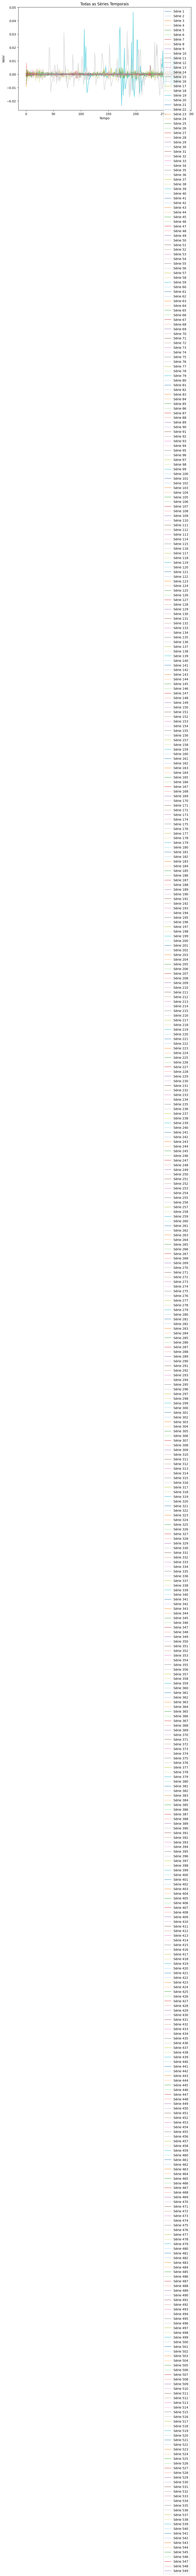

In [227]:
import matplotlib.pyplot as plt
import numpy as np

# Supondo que X seja uma matriz com dimensões (549, seq_len)
# Cada linha representa uma série temporal

# Criar o gráfico
plt.figure(figsize=(10, 6))

# Usar a paleta de cores "tab20"
colors = plt.cm.tab20(np.linspace(0, 1, 20))

for i in range(len(X)):
    plt.plot(X[i], color=colors[i % 20], alpha=0.7, label=f'Série {i+1}')

plt.title('Todas as Séries Temporais')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.show()


essa parte do codigo faz xxxxx

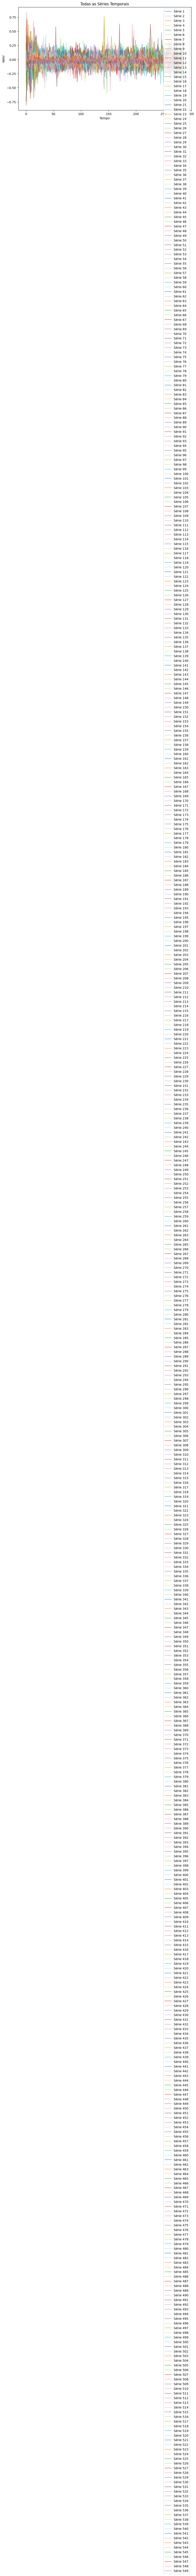

In [229]:
import matplotlib.pyplot as plt
import numpy as np

# Supondo que X seja uma matriz com dimensões (549, seq_len)
# Cada linha representa uma série temporal

# Criar o gráfico
plt.figure(figsize=(10, 6))

# Usar a paleta de cores "tab20"
colors = plt.cm.tab20(np.linspace(0, 1, 20))

for i in range(len(X)):
    plt.plot(X[i], color=colors[i % 20], alpha=0.7, label=f'Série {i+1}')

plt.title('Todas as Séries Temporais')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [185]:
import numpy as np
from tsai.models.ResNet import ResNet
from tsai.models.XceptionTime import XceptionTime

learn =TSClassifier(X, y, metrics=accuracy, arch=XceptionTime, train_metrics=True, bs=16)
learn.fit(10)

epoch,train_loss,accuracy,time
0,0.326349,0.439338,00:10
1,0.294519,0.441176,00:15
2,0.284057,0.443015,00:11


KeyboardInterrupt: 

In [137]:
m = RNN(c_in, c_out, hidden_size=100,n_layers=2,bidirectional=True,rnn_dropout=.5,fc_dropout=.5)
print(m)
print(count_parameters(m))
m(xb).shape

RNN(
  (rnn): RNN(1, 100, num_layers=2, bias=False, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=200, out_features=2, bias=True)
)
80602


torch.Size([1, 2])

In [138]:
m = LSTM(c_in, c_out, hidden_size=100,n_layers=2,bidirectional=True,rnn_dropout=.5,fc_dropout=.5)
print(m)
print(count_parameters(m))
m(xb).shape

LSTM(
  (rnn): LSTM(1, 100, num_layers=2, bias=False, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=200, out_features=2, bias=True)
)
321202


torch.Size([1, 2])

In [139]:
m = GRU(c_in, c_out, hidden_size=100,n_layers=2,bidirectional=True,rnn_dropout=.5,fc_dropout=.5)
print(m)
print(count_parameters(m))
m(xb).shape

GRU(
  (rnn): GRU(1, 100, num_layers=2, bias=False, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=200, out_features=2, bias=True)
)
241002


torch.Size([1, 2])

## Converting a model to TorchScript

In [140]:
model = LSTM(c_in, c_out, hidden_size=100, n_layers=2, bidirectional=True, rnn_dropout=.5, fc_dropout=.5)
model.eval()
inp = torch.rand(1, c_in, 50)
output = model(inp)
print(output)

tensor([[-0.0158, -0.0008]], grad_fn=<AddmmBackward0>)


### Tracing

In [141]:
# save to gpu, cpu or both
traced_cpu = torch.jit.trace(model.cpu(), inp)
print(traced_cpu)
torch.jit.save(traced_cpu, "cpu.pt")

# load cpu or gpu model
traced_cpu = torch.jit.load("cpu.pt")
test_eq(traced_cpu(inp), output)

!rm "cpu.pt"

LSTM(
  original_name=LSTM
  (rnn): LSTM(original_name=LSTM)
  (dropout): Dropout(original_name=Dropout)
  (fc): Linear(original_name=Linear)
)


'rm' is not recognized as an internal or external command,
operable program or batch file.


### Scripting

In [142]:
# save to gpu, cpu or both
scripted_cpu = torch.jit.script(model.cpu())
print(scripted_cpu)
torch.jit.save(scripted_cpu, "cpu.pt")

# load cpu or gpu model
scripted_cpu = torch.jit.load("cpu.pt")
test_eq(scripted_cpu(inp), output)

!rm "cpu.pt"

RecursiveScriptModule(
  original_name=LSTM
  (rnn): RecursiveScriptModule(original_name=LSTM)
  (dropout): RecursiveScriptModule(original_name=Dropout)
  (fc): RecursiveScriptModule(original_name=Linear)
)


'rm' is not recognized as an internal or external command,
operable program or batch file.


## Converting a model to ONNX

#| onnx
```python
import onnx

# Export the model
torch.onnx.export(model.cpu(),               # model being run
                  inp,                       # model input (or a tuple for multiple inputs)
                  "cpu.onnx",                # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  verbose=False,
                  opset_version=13,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={
                      'input'  : {0 : 'batch_size'}, 
                      'output' : {0 : 'batch_size'}} # variable length axes
                 )

# Load the model and check it's ok
onnx_model = onnx.load("cpu.onnx")
onnx.checker.check_model(onnx_model)

# You can ignore the WARNINGS below
```

#| onnx
```python
import onnxruntime as ort

ort_sess = ort.InferenceSession('cpu.onnx')
out = ort_sess.run(None, {'input': inp.numpy()})

# input & output names
input_name = ort_sess.get_inputs()[0].name
output_name = ort_sess.get_outputs()[0].name

# input dimensions
input_dims = ort_sess.get_inputs()[0].shape
print(input_name, output_name, input_dims)

test_close(out, output.detach().numpy())
!rm "cpu.onnx"
```

## Export -

In [143]:
#|eval: false
#|hide
from tsai.export import get_nb_name; nb_name = get_nb_name(locals())
from tsai.imports import create_scripts; create_scripts(nb_name)

ModuleNotFoundError: No module named 'nbdev'